In [9]:
#loading data
from scipy.io import loadmat  # this is the SciPy module that loads mat-files
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
mat = loadmat('MBN19_Zstacks_all_bigR.mat') 
mdata = mat['Dataset']  # variable in mat file
mdtype = mdata.dtype


df = pd.DataFrame(mdata,
                  columns = ['moments', 'minmax_scaled', 'minpeaks', 'maxpeaks',
                             'sum_peaks', 'r_minmax', 'r1','r2','r3',
                             'r4', 'r5', 'r6', 'r7', 'r8', 'r9',
                             'r10', 'r11', 'r12','r13', 'r14', 'r15',
                             'r16', 'r17', 'r18', 'r19', 'r20', 'r21',
                             'r22', 'r23', 'r24', 'r25', 'r26', 'r27','r28','r29',
                             'r30','r31','r32','r33','r34','r35','r36','r37','r38',
                             'r39','r40','Z_labels']
                 )
df.loc[df['minpeaks'] >= 2, 'minpeaks'] = 2
df.loc[df['maxpeaks'] >= 2, 'maxpeaks'] = 2

In [10]:
from sklearn.model_selection import StratifiedShuffleSplit

dropped_labels = ["sum_peaks","Z_labels"]

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(df, df["Z_labels"]):
    strat_train_set = df.loc[train_index]
    strat_test_set = df.loc[test_index]

X_test = strat_test_set.drop(dropped_labels, axis=1)
Y_test = strat_test_set["Z_labels"].copy()

train_X= strat_train_set.drop(dropped_labels, axis=1)
Y_train = strat_train_set["Z_labels"].copy()

In [11]:
#processing data
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from factor_analyzer import FactorAnalyzer
from sklearn.compose import ColumnTransformer

num_attribs = ['moments', 'minmax_scaled', 'r_minmax', 'r1','r2','r3',
                             'r4', 'r5', 'r6', 'r7', 'r8', 'r9',
                             'r10', 'r11', 'r12','r13', 'r14', 'r15',
                             'r16', 'r17', 'r18', 'r19', 'r20', 'r21',
                             'r22', 'r23', 'r24', 'r25', 'r26', 'r27','r28','r29',
                             'r30','r31','r32','r33','r34','r35','r36','r37','r38',
                             'r39','r40']   

# cat_attribs = ['minpeaks','maxpeaks']

factored_num_pipeline = Pipeline([
    ("Factor_analysis", FactorAnalyzer(n_factors=12, rotation="varimax")),
])
#consider re-writing the scripts such that no categorical features
#included in the analysis - leads to smoother 
# full_pipeline = ColumnTransformer([
#     ("num", factored_num_pipeline, num_attribs), #call the num_pipeline defined above on numerical attribs
#     ("cat", OneHotEncoder(handle_unknown="ignore"), cat_attribs), #call OneHotEncoder on categorical attribs
# ])

# train_X_final = full_pipeline.fit_transform(train_X)
train_X_final = factored_num_pipeline.fit_transform(train_X[num_attribs].copy())

In [17]:
# joblib.dump(full_pipeline, 'pipeline_MBN19_Track.pkl', compress = 1)
joblib.dump(factored_num_pipeline, 'pipeline_MBN19_Track_nocat.pkl', compress = 1)

['pipeline_MBN19_Track_nocat.pkl']

In [14]:
# #grid search of the best parameters - random forest
# from sklearn.model_selection import GridSearchCV
# from sklearn.ensemble import ExtraTreesRegressor


# param_grid = [{'n_estimators': [1000], 'max_features': [12,14,None], 'max_depth': [35,40,45]}]
# extra_trees_reg = ExtraTreesRegressor(n_jobs=-1, verbose=False, random_state=42)
# grid_search = GridSearchCV(extra_trees_reg, param_grid, cv=5, scoring="neg_mean_squared_error", return_train_score=True)
# grid_search.fit(X_train_final, Y_train)

# cvres = grid_search.cv_results_
# for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
#     print(np.sqrt(-mean_score), params)
#     #max depth 40, max features none, n estimators 1000
    
from sklearn.ensemble import ExtraTreesRegressor
extra_trees_reg = ExtraTreesRegressor(n_estimators=1000, max_features=None, max_depth = 40 ,verbose=False, random_state=42, n_jobs=-1)
extra_trees_reg.fit(train_X_final,Y_train)


ExtraTreesRegressor(max_depth=40, max_features=None, n_estimators=1000,
                    n_jobs=-1, random_state=42, verbose=False)

In [12]:
#transforming test data with pipeline on train
# X_test_final = full_pipeline.transform(X_test)
X_test_final = factored_num_pipeline.transform(X_test[num_attribs].copy())

Residuals without removing outliers: 0.5577448330207612 
 Residuals with outliers removed: 0.533788202661276
num outliers: 25, % outliers: 0.004642525533890436


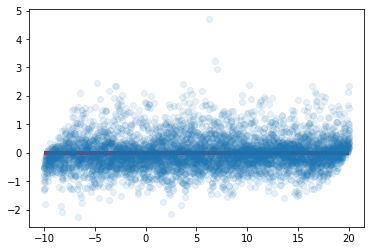

In [15]:
#fitting RF regressor
from sklearn.metrics import mean_squared_error

def Tukey_IQR(array, low=25, high=75, outlier_var = 1.5):
    import numpy as np
    LQR = np.percentile(array, low)
    UQR = np.percentile(array, high)
    IQR = UQR-LQR
    return LQR - outlier_var*IQR, UQR + outlier_var*IQR

def Tukey_outlier_detection(array, low=25, high=75, outlier_var=1.5):
    L, H = Tukey_IQR(array, low, high, outlier_var)
    return np.where((array < L) | (array > H))[0]

final_predictions = extra_trees_reg.predict(X_test_final)
# final_predictions = model.predict(X_test_final)
residuals = Y_test.to_numpy()-final_predictions

outliers = Tukey_outlier_detection(residuals, outlier_var=3) #due to poor labelling
Y_test_no_outliers = np.delete(Y_test.to_numpy(),(outliers))
residuals_no_outliers = np.delete(residuals,(outliers))
final_preds_no_outliers = np.delete(final_predictions,(outliers))

plt.plot(Y_test,residuals,'o', alpha=0.1)
# plt.plot(Y_test_no_outliers,residuals_no_outliers,'o', alpha=0.1)
plt.hlines(0,min(Y_test),max(Y_test),color='r',linewidth=4)
print(f"Residuals without removing outliers: {np.sqrt(mean_squared_error(Y_test, final_predictions))} \n Residuals with outliers removed: {np.sqrt(mean_squared_error(Y_test_no_outliers, final_preds_no_outliers))}")
print(f"num outliers: {len(outliers)}, % outliers: {len(outliers)/len(strat_test_set)}")

In [16]:
#save model
import joblib
joblib.dump(extra_trees_reg, "MBN19_ERT_model_final_nocat.pkl")

['MBN19_ERT_model_final_nocat.pkl']

In [5]:
import joblib
model = joblib.load("MBN19_ERT_model_final.pkl")

Residuals without removing outliers (labelling): 0.5619426243109616 
 Residuals with outliers removed: 0.5285777069427224
num outliers: 30, % outliers: 0.005571030640668524


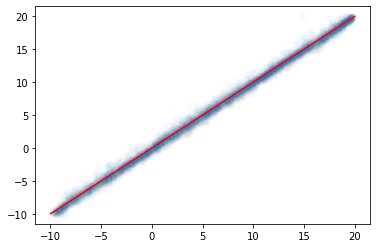

In [16]:
#model prediction
from sklearn.metrics import mean_squared_error

def Tukey_IQR(array, low=25, high=75, outlier_var = 1.5):
    import numpy as np
    LQR = np.percentile(array, low)
    UQR = np.percentile(array, high)
    IQR = UQR-LQR
    return LQR - outlier_var*IQR, UQR + outlier_var*IQR

def Tukey_outlier_detection(array, low=25, high=75, outlier_var=1.5):
    L, H = Tukey_IQR(array, low, high, outlier_var)
    return np.where((array < L) | (array > H))[0]


predictions = model.predict(X_test_final)

residuals = Y_test.ravel()-predictions.ravel()

outliers = Tukey_outlier_detection(residuals.ravel(), outlier_var=3) #due to poor labelling
Y_test_no_outliers = np.delete(Y_test.ravel(),(outliers))
residuals_no_outliers = np.delete(residuals,(outliers))
final_preds_no_outliers = np.delete(predictions.ravel(),(outliers))
%matplotlib inline
# plt.plot(Y_test,residuals,'o', alpha=0.1)
plt.plot(predictions,Y_test,'o', alpha=0.01)
plt.plot(Y_test,Y_test,'r-', linewidth=1)
# plt.plot(Y_test_no_outliers,residuals_no_outliers,'o', alpha=0.1)
# plt.hlines(0,min(Y_test),max(Y_test),color='r',linewidth=4)
print(f"Residuals without removing outliers (labelling): {np.sqrt(mean_squared_error(Y_test.ravel(), predictions.ravel()))} \n Residuals with outliers removed: {np.sqrt(mean_squared_error(Y_test_no_outliers, final_preds_no_outliers))}")
print(f"num outliers: {len(outliers)}, % outliers: {len(outliers)/len(Y_test)}")